Dans ce script, on cherche à démontrer que les réseaux CNN classiques ne sont pas suffisants pour la classification d'images frugales. 

#

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from PIL import Image
import xml.etree.ElementTree as ET
import shutil
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
import cv2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping

In [10]:
# Chemin vers les données
data_dir = os.path.join(os.path.dirname(os.getcwd()) + '/OpenSARShip')
print(data_dir)

selected_classes = ['Cargo', 'Tanker', 'Other Type', 'Tug', 'Fishing', 'Dredging', 'Passenger']

c:\Users\Julia Fouchier\Projet_syteme_3A/OpenSARShip


In [7]:
train_dir = os.path.join(data_dir, 'TRAIN')
test_dir = os.path.join(data_dir, 'TEST')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [11]:
# Boucle sur chaque classe pour diviser les données
for class_name in selected_classes:
    class_path = os.path.join(data_dir, class_name)
    train_class_dir = os.path.join(train_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)
    
    # Créer les dossiers de classe s'ils n'existent pas déjà
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)
    
    # Lister les fichiers dans la classe
    files = os.listdir(class_path)
    
    # Diviser les données en ensembles d'entraînement et de test
    train_files, test_files = train_test_split(files, test_size=0.3, random_state=42)
    
    # Copier les fichiers d'entraînement dans le dossier d'entraînement de la classe
    for file in train_files:
        src = os.path.join(class_path, file)
        dst = os.path.join(train_class_dir, file)
        shutil.copy(src, dst)
    
    # Copier les fichiers de test dans le dossier de test de la classe
    for file in test_files:
        src = os.path.join(class_path, file)
        dst = os.path.join(test_class_dir, file)
        shutil.copy(src, dst)

In [16]:
def charger_images(data_dir, img_size=(96, 96)):
    images = []
    labels = []
    
    # Charger les images et les étiquettes
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            
            # Charger l'image, la redimensionner et convertir en tableau numpy
            img = load_img(img_path, target_size=img_size)
            img = img_to_array(img)
            
            # Normaliser l'image en mettant à l'échelle les valeurs de pixel entre 0 et 1
            img = img / 255.0
            
            images.append(img)
            labels.append(class_name)
    
    images = np.array(images)
    labels = np.array(labels)
    
    # Convertir les étiquettes en encodage one-hot
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    labels_one_hot = to_categorical(labels_encoded)
    
    return images, labels_one_hot, label_encoder.classes_


In [17]:
# Charger les données d'entraînement
train_data_dir = os.path.join(data_dir, 'TRAIN')
train_images, train_labels, classes = charger_images(train_data_dir)

# Charger les données de test
test_data_dir = os.path.join(data_dir, 'TEST')
test_images, test_labels, _ = charger_images(test_data_dir)

# Afficher le nombre d'images par catégorie pour les ensembles d'entraînement et de test
for i, class_name in enumerate(classes):
    train_count = np.sum(train_labels[:, i])
    test_count = np.sum(test_labels[:, i])
    print(f"Classe {class_name}: Entraînement - {train_count} images, Test - {test_count} images")

Classe Cargo: Entraînement - 5768.0 images, Test - 2472.0 images
Classe Dredging: Entraînement - 56.0 images, Test - 24.0 images
Classe Fishing: Entraînement - 88.0 images, Test - 38.0 images
Classe Other Type: Entraînement - 659.0 images, Test - 283.0 images
Classe Passenger: Entraînement - 26.0 images, Test - 12.0 images
Classe Tanker: Entraînement - 1169.0 images, Test - 501.0 images
Classe Tug: Entraînement - 123.0 images, Test - 53.0 images


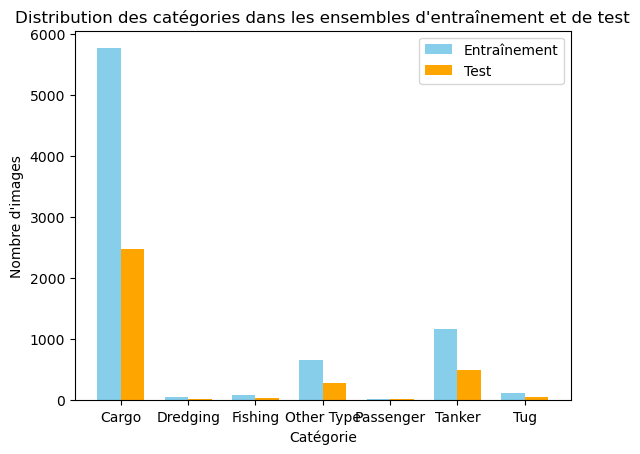

In [19]:
def plot_combined_histogram(labels, train_counts, test_counts):
    width = 0.35  # Largeur des barres

    fig, ax = plt.subplots()
    train_bars = ax.bar(np.arange(len(labels)), train_counts, width, label='Entraînement', color='skyblue')
    test_bars = ax.bar(np.arange(len(labels)) + width, test_counts, width, label='Test', color='orange')

    ax.set_xlabel('Catégorie')
    ax.set_ylabel('Nombre d\'images')
    ax.set_title('Distribution des catégories dans les ensembles d\'entraînement et de test')
    ax.set_xticks(np.arange(len(labels)) + width / 2)
    ax.set_xticklabels(labels)
    ax.legend()

    plt.show()

# Obtenir le nombre d'images par catégorie pour l'ensemble d'entraînement
train_counts = np.sum(train_labels, axis=0)

# Obtenir le nombre d'images par catégorie pour l'ensemble de test
test_counts = np.sum(test_labels, axis=0)

# Tracer l'histogramme combiné
plot_combined_histogram(classes, train_counts, test_counts)

In [33]:
# One-Hot Encode les étiquettes d'entraînement
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels.argmax(axis=1))

In [46]:
# Définition des hyperparamètres
batch_size = 64
epochs = 30
input_shape = (96, 96, 3)
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.CategoricalCrossentropy()

In [49]:
# Definition of the simplified CNN architecture
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 1)),
    MaxPooling2D((2,2)),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(120, activation='relu'),
    Dense(, activation='softmax')
])

model.compile(optimizer=optimizer, loss = loss, metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 94, 94, 16)        448       
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 47, 47, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 45, 45, 32)        4640      
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 22, 22, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 20, 20, 64)        18496     
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 10, 10, 64)       

In [36]:
# Définir un callback pour arrêter l'entraînement tôt si la validation accuracy cesse de s'améliorer
early_stopping_callback = EarlyStopping(monitor='val_accuracy', 
                                       patience=5, 
                                       mode='max', 
                                       verbose=1)

In [37]:
print(test_images.shape)
print(test_labels.shape)

(3383, 96, 96, 3)
(3383, 7)


In [47]:
hist = model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(test_images, test_labels), callbacks=[early_stopping_callback])

Epoch 1/30
124/124 [==============================] - 63s 456ms/step - loss: 0.2966 - accuracy: 0.8888 - val_loss: 0.9871 - val_accuracy: 0.7360
Epoch 2/30
124/124 [==============================] - 63s 508ms/step - loss: 0.2435 - accuracy: 0.9111 - val_loss: 1.0217 - val_accuracy: 0.7292
Epoch 3/30
124/124 [==============================] - 59s 476ms/step - loss: 0.2158 - accuracy: 0.9215 - val_loss: 1.0774 - val_accuracy: 0.7331
Epoch 4/30
124/124 [==============================] - 58s 473ms/step - loss: 0.1949 - accuracy: 0.9272 - val_loss: 1.1645 - val_accuracy: 0.7210
Epoch 5/30
124/124 [==============================] - 56s 452ms/step - loss: 0.1754 - accuracy: 0.9352 - val_loss: 1.3685 - val_accuracy: 0.7502
Epoch 6/30
124/124 [==============================] - 56s 451ms/step - loss: 0.1448 - accuracy: 0.9509 - val_loss: 1.4384 - val_accuracy: 0.7325
Epoch 7/30
124/124 [==============================] - 55s 447ms/step - loss: 0.1267 - accuracy: 0.9563 - val_loss: 1.4810 - val_ac

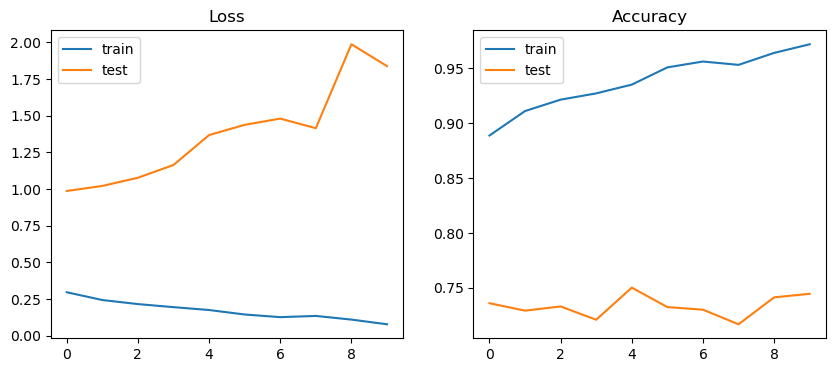

In [48]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='test')
plt.title('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='test')
plt.title('Accuracy')
plt.legend()
plt.show()

106/106 [==============================] - 14s 72ms/step


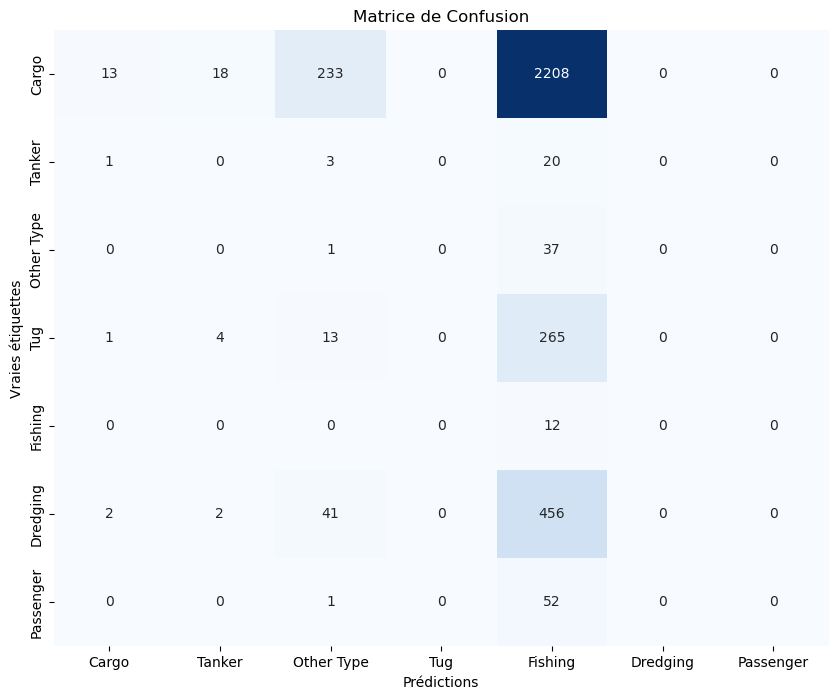


Rapport de classification :
              precision    recall  f1-score   support

       Cargo       0.76      0.01      0.01      2472
      Tanker       0.00      0.00      0.00        24
  Other Type       0.00      0.03      0.01        38
         Tug       0.00      0.00      0.00       283
     Fishing       0.00      1.00      0.01        12
    Dredging       0.00      0.00      0.00       501
   Passenger       0.00      0.00      0.00        53

    accuracy                           0.01      3383
   macro avg       0.11      0.15      0.00      3383
weighted avg       0.56      0.01      0.01      3383



c:\Users\Julia Fouchier\anaconda3\envs\tensorflow_new\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Julia Fouchier\anaconda3\envs\tensorflow_new\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Julia Fouchier\anaconda3\envs\tensorflow_new\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [53]:
from sklearn.metrics import confusion_matrix, classification_report
# Obtenez les prédictions du modèle
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Convertissez les étiquettes one-hot réelles en entiers
true_labels = np.argmax(test_labels, axis=1)

# Calculez la matrice de confusion
confusion_mat = confusion_matrix(true_labels, predicted_labels)

# Définissez les noms de classes réels
class_names = selected_classes  # Remplacez par vos noms de classes réels

# Créez un DataFrame pour la matrice de confusion
confusion_df = pd.DataFrame(confusion_mat, index=class_names, columns=class_names)

# Tracez la heatmap de la matrice de confusion
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.show()

# Affichez un rapport de classification
print("\nRapport de classification :")
print(classification_report(true_labels, predicted_labels, target_names=class_names))


# Test du CNN du document

In [ ]:
# Définition des hyperparamètres
batch_size = 64
epochs = 30
input_shape = (96, 96, 3)
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.CategoricalCrossentropy()

# Definition of the simplified CNN architecture
model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D((2,2)),
    
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

model.compile(optimizer=optimizer, loss = loss, metrics=['accuracy'])

model.summary()